In [28]:
# !apt install -y build-essential swig curl
# !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
# !pip install auto-sklearn


In [29]:
# !pip3 install scikit-learn

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that get preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import autosklearn.classification



/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [32]:
sample = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

# Exploratory Data Analysis

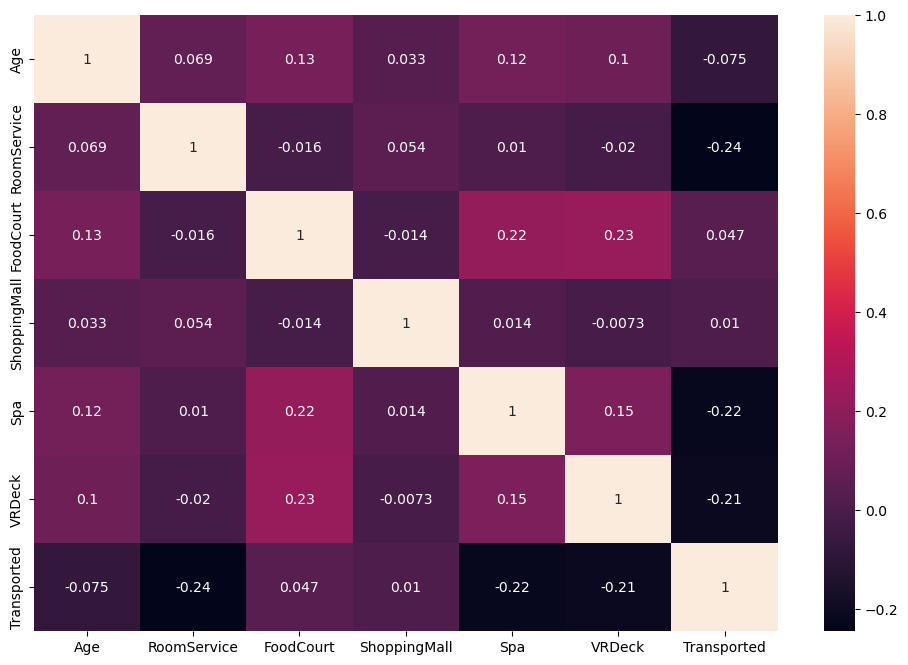

In [33]:
train.corr()

plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True)
plt.show()

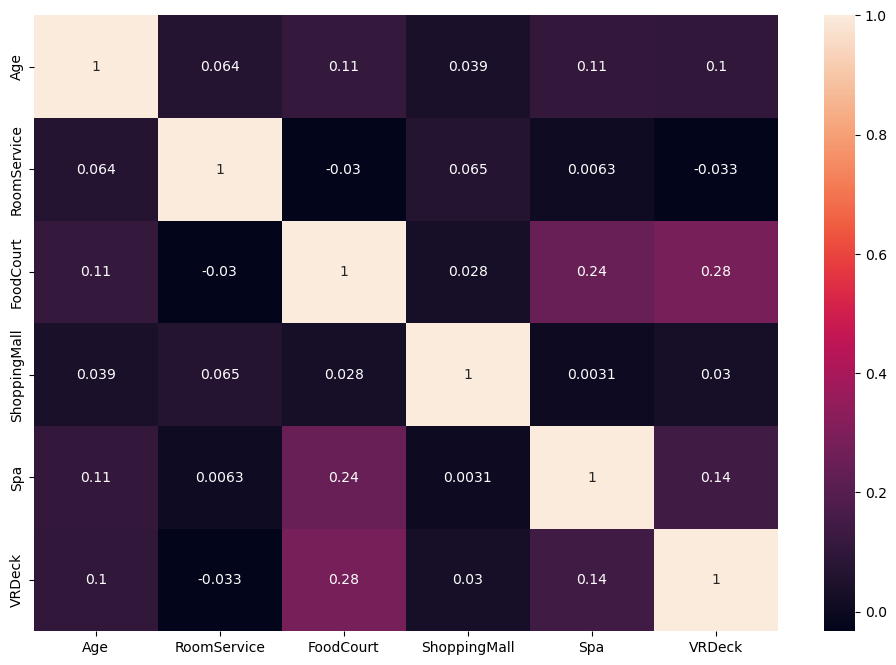

In [34]:
test.corr()

plt.figure(figsize=(12,8))
sns.heatmap(test.corr(), annot=True)
plt.show()

# Preprocess

In [35]:
#do imputation
imp_mean   = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mode   = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [36]:
def preprocess(df):
    
    #split cabin into 3 features
    df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df.Cabin.str.split("/", expand=True)
    
    #drop unnecessary variables
    df.drop(['Cabin','Name', 'PassengerId'], axis=1, inplace=True)
    
    #reorder columns for simplicity
    if('Transported' in df.columns.tolist()):
        df = df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', #removed PassengerId
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_Deck', 'Cabin_Num', 'Cabin_Side', 'Transported']]
    else:
        df = df[['HomePlanet', 'CryoSleep', 'Destination', 'Age', #removed PassengerId
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_Deck', 'Cabin_Num', 'Cabin_Side']]
    
    return df

Check all the unique values available in each features.

In [37]:
for col in train.columns:
    print(col+": ",len(pd.unique(train[col])), " ("+str(train[col].dtype)+")")

PassengerId:  8693  (object)
HomePlanet:  4  (object)
CryoSleep:  3  (object)
Cabin:  6561  (object)
Destination:  4  (object)
Age:  81  (float64)
VIP:  3  (object)
RoomService:  1274  (float64)
FoodCourt:  1508  (float64)
ShoppingMall:  1116  (float64)
Spa:  1328  (float64)
VRDeck:  1307  (float64)
Name:  8474  (object)
Transported:  2  (bool)


In [38]:
train_data = preprocess(train.copy())
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,A,98,P,False
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,G,1499,S,False
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,G,1500,S,True
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,E,608,S,False


In [39]:
train_data.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Cabin_Deck      199
Cabin_Num       199
Cabin_Side      199
Transported       0
dtype: int64

## Data Imputation for Training Data

In [40]:
#categorial & numerical data
cat_columns = ['HomePlanet','CryoSleep','Destination','VIP','Cabin_Deck', 'Cabin_Num','Cabin_Side']
train_data[cat_columns] = imp_mode.fit_transform(train_data[cat_columns])
num_columns = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
train_data[num_columns] = imp_median.fit_transform(train_data[num_columns])

In [41]:
le = LabelEncoder()
train_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform)

# Checking for Outliers 

In [42]:
train_data.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.649833,0.349362,1.494306,28.790291,0.022892,220.009318,448.434027,169.572300,304.588865,298.261820,4.321293,962.495801,0.516162
std,0.795183,0.476796,0.814966,14.341404,0.149568,660.519050,1595.790627,598.007164,1125.562559,1134.126417,1.760826,508.669969,0.499767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,523.000000,0.000000
50%,0.000000,0.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1009.000000,1.000000
75%,1.000000,1.000000,2.000000,37.000000,0.000000,41.000000,61.000000,22.000000,53.000000,40.000000,6.000000,1363.000000,1.000000
max,2.000000,1.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,7.000000,1816.000000,1.000000


In [43]:
train_data.median()

HomePlanet         0.0
CryoSleep          0.0
Destination        2.0
Age               27.0
VIP                0.0
RoomService        0.0
FoodCourt          0.0
ShoppingMall       0.0
Spa                0.0
VRDeck             0.0
Cabin_Deck         5.0
Cabin_Num       1009.0
Cabin_Side         1.0
Transported        1.0
dtype: float64

# Feature Scaling

We do Min Max Normalization. First we split the training data into X and Y dataframes. Then identify the variables with highest variance and scale them between 0 and 1.

In [44]:
#split X and Y in train data
train_x = train_data.loc[:,'HomePlanet':'Cabin_Side']
train_y = train_data.loc[:,'Transported']

In [45]:
variance = np.var(train_data)
print(variance)
highvar_cols = [col for col in train_data.columns if variance[col] > 2]
print(highvar_cols)

HomePlanet      6.322434e-01
CryoSleep       2.273081e-01
Destination     6.640939e-01
Age             2.056522e+02
VIP             2.236794e-02
RoomService     4.362352e+05
FoodCourt       2.546255e+06
ShoppingMall    3.575714e+05
Spa             1.266745e+06
VRDeck          1.286095e+06
Cabin_Deck      3.100153e+00
Cabin_Num       2.587154e+05
Cabin_Side      2.497388e-01
Transported     2.499869e-01
dtype: float64
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Deck', 'Cabin_Num']


In [46]:
train_x_scaled = train_x.copy()
scaler = MinMaxScaler(feature_range=(0.0,1.0))
train_x_scaled[highvar_cols] = scaler.fit_transform(train_x_scaled[highvar_cols])
train_x_scaled

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side
0,1,0,2,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0
1,0,0,2,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,0.714286,0.000000,1
2,1,0,2,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0.000000,0.000000,1
3,1,0,2,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0.000000,0.000000,1
4,0,0,2,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,0.714286,0.000551,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0.518987,1,0.000000,0.228726,0.000000,0.073322,0.003066,0.000000,0.988436,0
8689,0,1,1,0.227848,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,0.301762,1
8690,0,0,2,0.329114,0,0.000000,0.000000,0.079687,0.000045,0.000000,0.857143,0.303414,1
8691,1,0,0,0.405063,0,0.000000,0.035186,0.000000,0.015753,0.134049,0.571429,0.762665,1


# Machine Learning Classifier Import and Training Accuracy
We use XGBoost Classifier and evaluate performance.

In [51]:
# xgb_cl = xgb.XGBClassifier(learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8, colsample_bytree=0.8)
# xgb_cl.fit(train_x_scaled, train_y)

# # Predict
# preds = xgb_cl.predict(train_x_scaled)

# # Score
# accuracy_score(train_y, preds)

In [52]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=10*60, #second
    per_run_time_limit=30, #second
    n_jobs=8
)
automl.fit(train_x_scaled, train_y)
preds = automl.predict(train_x_scaled)
print(accuracy_score(train_y, preds))
print(automl.sprint_statistics())

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  Parameters
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  Parameters
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own ri

0.9194754400092028
auto-sklearn results:
  Dataset name: 9763b7b0-d00f-11ed-844f-0242ac130202
  Metric: accuracy
  Best validation score: 0.812130
  Number of target algorithm runs: 114
  Number of successful target algorithm runs: 100
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 14
  Number of target algorithms that exceeded the memory limit: 0



# Test Result Generate

In [53]:
test_data = preprocess(test.copy())

test_data[cat_columns] = imp_mode.transform(test_data[cat_columns])
test_data[num_columns] = imp_median.transform(test[num_columns])

le = LabelEncoder()
test_data[cat_columns] = test_data[cat_columns].apply(le.fit_transform)

test_x_scaled = test_data.copy()
test_x_scaled[highvar_cols] = scaler.transform(test_x_scaled[highvar_cols])
test_x_scaled

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Num,Cabin_Side
0,0,1,2,0.341772,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,0.451542,1
1,0,0,2,0.240506,0,0.000000,0.000302,0.000000,0.125982,0.000000,0.714286,0.510463,1
2,1,1,0,0.392405,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,1
3,1,0,2,0.481013,0,0.000000,0.223124,0.000000,0.008077,0.024241,0.285714,0.000551,1
4,0,0,2,0.253165,0,0.000698,0.000000,0.027030,0.000000,0.000000,0.714286,0.566630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0.430380,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.857143,0.248899,1
4273,0,0,2,0.531646,0,0.000000,0.028410,0.000724,0.000446,0.005967,0.714286,0.737335,1
4274,2,1,0,0.341772,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.449339,0
4275,1,0,2,0.341772,0,0.000000,0.089894,0.000000,0.000000,0.021672,0.428571,0.449890,0


In [54]:
# test_preds = xgb_cl.predict(test_x_scaled)

In [55]:
test_preds = automl.predict(test_x_scaled)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SimpleImputer 

In [56]:
data = {'PassengerId':np.squeeze(test[['PassengerId']].values), 
        'Transported':test_preds}
result = pd.DataFrame(data)
result.Transported.replace([0, 1], [False, True], inplace=True)
result

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [58]:
result.to_csv("submission.csv",index=False, header=True)